<a href="https://colab.research.google.com/github/Laryssafsp/DIO-Ciencia-de-Dados-Python/blob/main/Python-ML-Pr%C3%A1tica/Rede_neural_do_zero_DIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rede Neural
Implementando uma Deep Learning do zero em Python

In [16]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [13]:
transform = transforms.ToTensor() #define conversão imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # carrega a parte do treino no dataset
trainload = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # cria buffer dos dados para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # carrega a parte do treino no dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)# cria buffer dos dados para pegar os dados por partes

#diretor IA no facebook yann.lecun

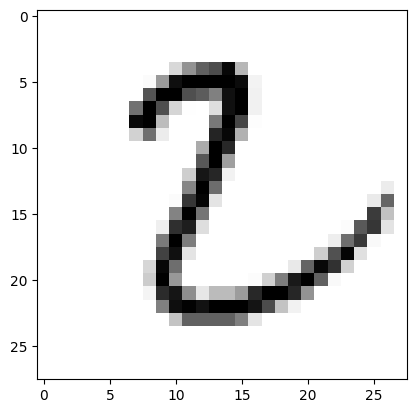

In [17]:
dataiter = iter(trainload)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [18]:
print(imagens[0].shape) #verificar dimensões do tensor
print(etiquetas[0].shape)#verificar dimensões etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [23]:
class Modelo(nn.Module):
  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neurônios que se ligam a 128
    self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neurôios que se ligam a 64
    self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neurôios que se ligam a 10
# para a camada de sáida não é necessário definir nada, pois só precisamos pegar o output da camada interna 2

  def forward(self, X):
    X = F.relu(self.linear1(X)) # função de ativação da camada de entrar a para a camada interna 1
    X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 apara a camada interna 2
    X = self.linear3(X) # função de ativação da camada interna 2 para a camda de saída, nesse cado f(x) = x
    return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda

In [26]:
def treino(modelo, trainloader, device):

  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a politica de atualização dos pesos e da bias
  inicio = time() # timer para sabermos quanto tempo levou o treino

  criterio = nn.NLLLoss() # definindo o criterio para calcular a perda
  EPOCHS = 10 # numero de epochs que o algotirmo rodará - no mínimo 100
  modelo.train() # ativando o modo de treinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada = 0 # inicialização da perda acumulada de apoch em questão

    for imagens, etiquetas in trainloader:

      imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para "vetores" de 28*28 casas para ficarem compatíveis com a bias
      otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior

      output = modelo(imagens.to(device)) # colocando os dados no modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) #calculando a perda da epoch em questão

      perda_instantanea.backward() # back propagation a partir da perda

      otimizador.step() # atuaizando os pesos e a bias

      perda_acumulada += perda_instantanea.item()


    else:
      print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
  print("\nTempo de treino (em minutos) = ",(time()-inicio)/60)




In [25]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
        # desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo algo de processamento
      with torch.no_grad():
        logps = modelo(img.to(device)) # output do modelo em escala loogaritmica

      ps = torch.exp(logps) # converter output para escala normal (lembrando que é um tensor)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab)) # conveerter o tensor em um número, no caso, o numero que o modelo previu como correto
      etiqueta_certa = etiquetas.numpy()[i]
      if(etiqueta_certa == etiqueta_pred): # comparar a previsão com o valor correto
        conta_corretas += 1
      conta_todas += 1

    print("Total de imagens testadas =", conta_todas)
    print("\nPrecisão do modelo = {}%".format(conta_corretas*100*conta_todas))

In [27]:
#verificação
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)